# Assumptions

- Equidistanced spatial grid

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

#### Configure time array

In [2]:
t0 = 0.0
Nt = 51
dt = 0.1

t_arr = t0 + dt*np.arange(Nt)
print("time range: [{}, {}] a.u.".format(*t_arr[[0,-1]]))

time range: [0.0, 5.0] a.u.


#### Configure spatial array

In [3]:
Nx = 51
x_arr = np.linspace(0, 5.1, Nx)
dx = x_arr[1] - x_arr[0]
L = x_arr[-1] - x_arr[0]
print("dx: {}".format(dx))

# Set limit beyond which particles stop
box_xmin, box_xmax = x_arr[0], x_arr[-1]
stop_area_xmin, stop_area_xmax = x_arr[0], x_arr[-1]

dx: 0.102


#### Configure spatial potential energy

In [4]:
Vx = np.zeros_like(x_arr, dtype=float)

#### Configure initial state

In [5]:
wf_x_t0 = np.empty_like(x_arr, dtype=complex)
wf_x_t0[:] = np.sin(pi/L*x_arr) + 0.3*np.sin(2*pi/L*x_arr)
wf_x_t0 /= np.sqrt(np.trapz(np.square(np.abs(wf_x_t0)), x_arr))
wf_x_t0[[0,-1]] = 0.0  # for boundary condition

#### Configure unit

In [6]:
hbar, m = 1.0, 1.0

#### Configure propagator

In [7]:
from tdse.propagator.box1d import Time_Indep_Hamil_Propagator

prop = Time_Indep_Hamil_Propagator(Nx-2, dx, Vx[1:-1], mass=1.0)

#### Configure particles

In [8]:
xp_t0_arr = np.linspace(x_arr[2], x_arr[-3], 11)

# Propagate

In [9]:
from warnings import filterwarnings
filterwarnings('error')

# [TODO] Install fresh `scipy` package and fix only the relavent part, as minimal as possible but enough for this script to be run correctly. Control the version with `git`. Consider suggesting the modification to `scipy` society.

- [ ] evalution flow of iteration termination condition in `scipy.optimize.nonlin.TerminationCondition`
- [ ] applying limits on nonlinear solve during determination of `dx` in `scipy.optimize.nonlin.nonlin_solve()`

In [10]:
def g_func(_dxp, _xp, _x_arr, _dx, _wf_arr, _dt, _A, _b, _prop,
            _hbar, _m, _Ns, _lowers, _uppers, rfac=1e-3, _vv=False):

    _x = _xp + _dxp
    
#     # Determine `_is0` 
#     # : the first index of stencils for finite-difference method
#     _x = _xp + _dxp
#     _il = int((_x-_x_arr[0])//_dx)  # index of nearest-left x_arr point
#     _Nx = _x_arr.size
#     assert _Ns == 4  # formula for _is0 here is valid for `_Ns==4`
#     _is0 = _il - 1 + (1>_il)*(1-_il) + (Nx-3<_il)*((Nx-3)-_il)

#     # Solve to get wf and its derivatives at `_x`
#     _xi_minus_x = (_x_arr[_is0:_is0+_Ns] - _x)
#     _A[:,0] = 1.
#     for _i in range(1,_Ns): 
#         _A[:,_i] = _A[:,_i-1] * _xi_minus_x / _i
#     _b[:] = _wf_arr[_is0:_is0+_Ns]

#     try: _wf, _dx_wf, _dx2_wf, _dx2_wf = np.linalg.solve(_A, _b)
#     except np.linalg.LinAlgError as e:
#         raise RuntimeError("Failed to get wf at given x: {}".format(_x))
#     except: raise Exception("Unexpected error")

    _wf, _dx_wf = _prop.wf.eval_wf_with_wf_deriv_at_x(_x, _wf_arr)
        
    if _wf == 0: raise NotImplementedError

    # Evaluate Bohmian velocity field value
    _v = _hbar / _m * np.imag(_dx_wf / _wf)

    # Evaluate and return objective function value `_g`
    _g = -_dxp + _dt * _v

    return _g

In [11]:
# Initialize
xp_arr = np.empty_like(xp_t0_arr)
xp_arr[:] = xp_t0_arr
xp_arr_t = np.zeros((Nt, xp_arr.size))
xp_arr_t[0,:] = xp_arr

wf_x = np.empty_like(wf_x_t0)
wf_x[:] = wf_x_t0
wf_x_t = np.zeros((Nt,wf_x.size), dtype=wf_x.dtype)
wf_x_t[0,:] = wf_x


# Arrays for Finite Difference method
Ns = 4  # must be equal to `4` for velocity evaluation
A = np.empty((Ns,Ns), dtype=float)
b = np.empty((Ns,), dtype=complex)

# Check whether the spatial array has equal spacings
assert np.std(np.diff(x_arr)) < 1e-8 * np.mean(x_arr)
Nx, dt = x_arr.size, x_arr[1] - x_arr[0]


# For debug
g_args = None
dxp_g_list = []
def callback(dxp,g): 
    dxp_g_list.append((dxp[0],g[0]))
    print("[callback][dxp={:.16f}, g={:.16f}]".format(dxp[0],g[0]), end='\n\n')

    
# Iteration over time
MAX_SUBSTEP_COUNT = 20
MAX_ITER_COUNT = 100
PADDING_RATIO = 1.2
TIMESTEP_REDUCTION_RATIO = 0.8
MIN_TIMESTEP = 1e-8

from scipy.optimize import root
t = t_arr[0]
for it in range(Nt-1):
    
    assert t == t_arr[it]
    
    # Iterate over substeps within given time step
    for it_sub in range(MAX_SUBSTEP_COUNT):
        
        dt_upper_limit = t_arr[it+1] - t
        
        # Determine actual time step: `dt_min_xp`
        dt_min_xp = dt_upper_limit  # minimum of time steps among particles
        
        _Ns = 4  # should be `4`
        _A = np.empty((_Ns,_Ns), dtype=float)
        _b = np.empty((_Ns,), dtype=complex)
        for xp in xp_arr:
            
            _il = int((xp-x_arr[0])//dx)  # index of nearest-left x_arr point
            _is0 = _il - 1 + (1>_il)*(1-_il) + (Nx-3<_il)*((Nx-3)-_il)
            
            # Solve to get wf and its derivatives at `_x`
            _xi_minus_x = (x_arr[_is0:_is0+_Ns] - xp)
            _A[:,0] = 1.
            for _i in range(1,_Ns): 
                _A[:,_i] = _A[:,_i-1] * _xi_minus_x / _i
            _b[:] = wf_x[_is0:_is0+_Ns]
            
            try: _wf, _dx_wf, _dx2_wf, _dx2_wf = np.linalg.solve(_A, _b)
            except np.linalg.LinAlgError as e:
                raise RuntimeError("Failed to get wf at given x: {}".format(xp))
            except: raise Exception("Unexpected error")

            if _wf == 0: raise NotImplementedError

            # Evaluate Bohmian velocity field value
            v = hbar / m * np.imag(_dx_wf / _wf)

            for _ic in range(MAX_ITER_COUNT):
                # explicit euler with extended dt by PADDING_RATIO
                xp_next = xp + PADDING_RATIO * dt_min_xp * v
                if (x_arr[_is0] < xp_next) and (xp_next < x_arr[_is0+_Ns-1]): break
                else: dt_min_xp *= TIMESTEP_REDUCTION_RATIO
            if _ic >= MAX_ITER_COUNT: 
                raise Exception("Failed to find a timestep mimimum among particles")
        
        assert dt_min_xp > MIN_TIMESTEP
    
    
        # Propagate wavefunction `wf`
        prop.propagate(wf_x[1:-1], dt_min_xp, Nt=1)
    
        
        # Propagate particles
        for ip, xp in enumerate(xp_arr):

            # Stop a particle if it is out-of-range
            if not (stop_area_xmin < xp and xp < stop_area_xmax): continue

            # Find particle propagation step: `_dxp`
            _dxp0 = 0.0  # initial guess
            _g_args = (xp, x_arr, dx, wf_x, dt, A, b, prop,
                       hbar, m, Ns, box_xmin-xp, box_xmax-xp, 1e-3)
            _opt_broyden1 = {'xtol':1e0, 'nit':200, 
                             'lowers':box_xmin-xp, 'uppers':box_xmax-xp}
            _tot_opt = {'method':'broyden1', 'options': _opt_broyden1}

            _failed = False
            try: _sol = root(g_func, _dxp0, _g_args, **_tot_opt)
            except Exception as e: _failed = True

            if _failed or not _sol.success:
                g_args = _g_args
                dxp_g_list = []
                _g_args_at_err = _g_args + (True,)
                _tot_opt_at_err = { 'method':_tot_opt['method'], 'callback': callback, 
                                   'options': {**_opt_broyden1, 'disp':True}}
                try: _sol = root(g_func, _dxp0, _g_args_at_err, **_tot_opt_at_err)
                except Exception as e: print(e)
                _msg = ("Failed for time-index={}, "
                        "particle-position==xp_arr[{}]={:.4f}\n"
                        "opt_result:\n{}")
                raise Exception(_msg.format(it, ip, xp, _sol if not _failed else None))

            _dxp = _sol.x

            # Propagate particle by step just found: `_dxp`
            xp_arr[ip] += _dxp
        
        if dt_min_xp < dt_upper_limit:
            print("[t={:.4f}] time substep by dt_min_xp={:.5f}"
                  " / dt_upper_limit={:.5f}".format(t, dt_min_xp, dt_upper_limit))
            t += dt_min_xp
        elif dt_min_xp == dt_upper_limit:
            assert t_arr[it+1] == (t + dt_min_xp)
            t = t_arr[it+1]
            break
        else: raise Exception("Unexpected case: probably `dt_min_xp > dt_upper_limit`")
    
    if it_sub >= MAX_SUBSTEP_COUNT:
        raise Exception("Failed to propagate a timestep: MAX_SUBSTEP_COUNT reached")
    
    # Store
    xp_arr_t[it+1,:] = xp_arr
    wf_x_t[it+1,:] = wf_x

#### Visualize

In [12]:
pdf_x_t = np.square(np.abs(wf_x_t))

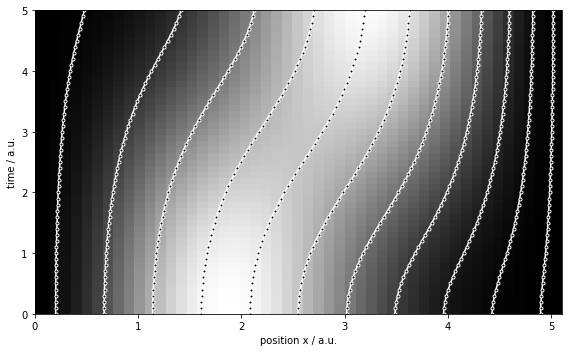

In [13]:
figsize=(8,5)
fig, ax = plt.subplots(figsize=figsize)

from vis.plot import construct_catesian_mesh_for_pcolormesh
x_cmesh, t_cmesh = construct_catesian_mesh_for_pcolormesh(x_arr, t_arr)
ax.pcolormesh(x_cmesh, t_cmesh, pdf_x_t.transpose(), cmap='gray')

for ip in range(xp_t0_arr.size):
    ax.plot(xp_arr_t[:,ip], t_arr, '.-', color='white', mfc='black')
    
ax.set_xlim(*x_arr[[0,-1]]), ax.set_ylim(*t_arr[[0,-1]])

ax.set_xlabel("position x / a.u."), ax.set_ylabel("time / a.u.")
fig.tight_layout()

# fig.savefig("particles-dx-{:.4f}-with-stepsize-control-for-avoiding-discontinity-of-fd-method-with-given-dt-{:.3f}-test-26.png".format(dx, dt))

# [CAUTION] When using `broyden1` method, set `xtol` (relative tolerance on x) in order to prevent `RuntimeWarning`

# ETC>

In [178]:
# Arrays for Finite Difference method
Ns = 4
A = np.empty((Ns,Ns), dtype=float)
A[:,0] = 1.
b = np.empty((Ns,), dtype=complex)


def ff(_x):
    Ns = 4
    _x_arr=x_arr
    _wf_arr = wf_x
    _A = A
    _b = b
    
    _dx = _x_arr[1] - _x_arr[0]

    _is0 = int((_x-_x_arr[0])//_dx)
    _Nx = _wf_arr.size
    if _is0 > _Nx//2: _is0 += -2
    _xi_minus_x = (_x_arr[_is0:_is0+Ns] - _x)
    _A[:,1] = _A[:,0] * _xi_minus_x / 1.
    _A[:,2] = _A[:,1] * _xi_minus_x / 2.
    _A[:,3] = _A[:,2] * _xi_minus_x / 3.
    _b[:] = _wf_arr[_is0:_is0+Ns]

    try: _wf, _dx_wf, _dx2_wf, _dx3_wf = np.linalg.solve(_A, _b)
    except np.linalg.LinAlgError as e:
        raise RuntimeError("Failed to get wf at given x: {}".format(_x))
    except: raise Exception("Unexpected error")

    if _wf == 0: raise NotImplementedError
    _v = np.imag(_dx_wf / _wf)
    _dx_v = np.imag( (_dx2_wf/_wf) - (_dx_wf/_wf)**2 )
    _dx_v1 = np.imag((_dx2_wf/_wf))
    _dx_v2 = -np.imag((_dx_wf/_wf)**2)
    _dx_wf_over_wf = _dx_wf / _wf
    _dx2_wf_over_wf = _dx2_wf / _wf
    return _wf, _dx_wf, _dx2_wf, _dx3_wf, _v, _dx_v, _dx_v1, _dx_v2, _dx_wf_over_wf, _dx2_wf_over_wf

In [179]:
# xxx = xp+np.linspace(-0.000005, 0.00001, 201)
xxx = x_arr[-2] + np.linspace(-0.0005, 0.0005, 201)
wf_dx_dx2 = np.array([ff(x) for x in xxx])

# [TODO] Use of 4-stencils seems to be required for 'continuous v', not just continous wf.

# [TODO] why are the jacobian of v, i.e. dx_v discontinous?

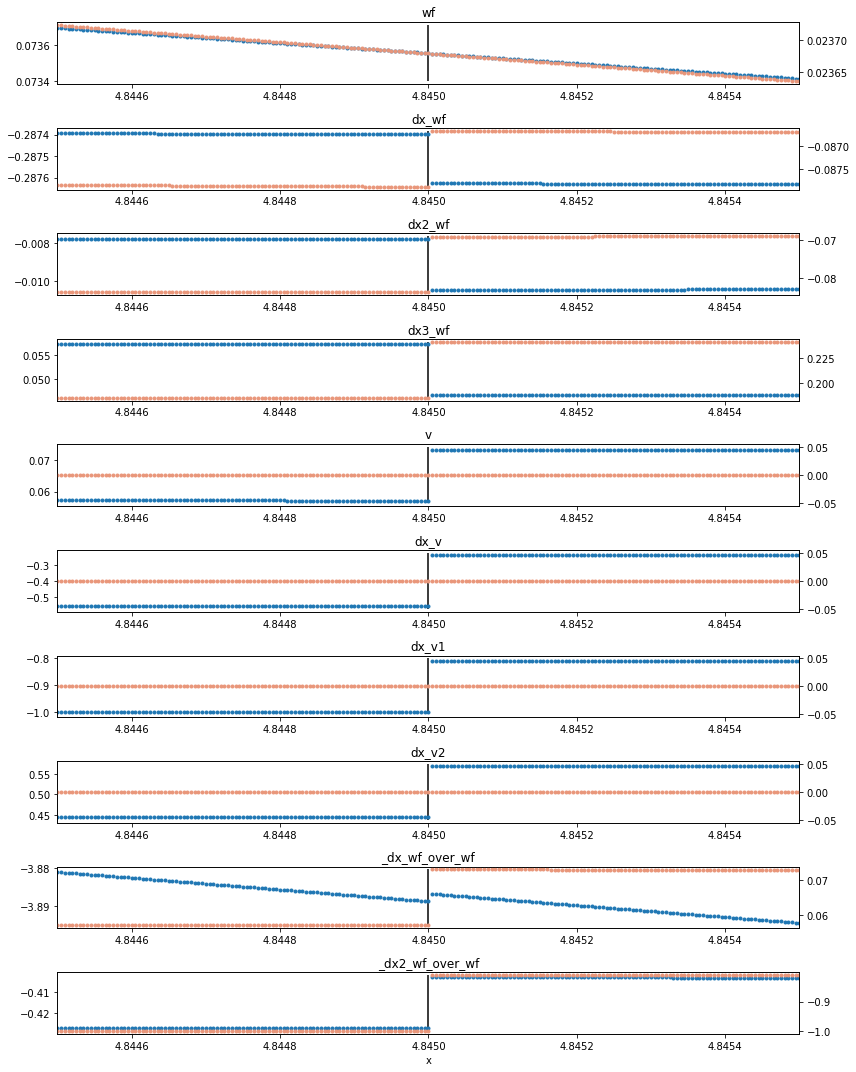

In [180]:
ax_titles = ('wf', 'dx_wf', 'dx2_wf', 'dx3_wf', 'v', 'dx_v', 'dx_v1', 'dx_v2', '_dx_wf_over_wf', '_dx2_wf_over_wf')

fig, axes = plt.subplots(nrows=len(ax_titles), figsize=(12,15))

for i, ax in enumerate(axes):
    ax.set_xlim(xxx[[0,-1]])
    ax.plot(xxx, wf_dx_dx2[:,i].real, '.')
#     if ax_titles[i] in ('_dx_wf_over_wf',):
    ax2 = ax.twinx()
    ax2.plot(xxx, wf_dx_dx2[:,i].imag, '.',color='darksalmon')
    
    ax.vlines(x_arr, *ax.get_ylim())
    ax.set_title(ax_titles[i])
axes[-1].set_xlabel("x")
fig.tight_layout()
# fig.savefig("discreteness-fd-4-stencil-test-9.png")

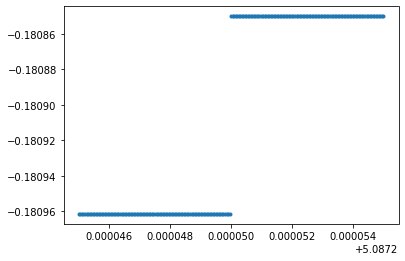

In [17]:
fig, ax = plt.subplots()
ax.plot(xxx, (wf_dx_dx2[:,-1]).imag, '.')

# ETC>

In [121]:
g_func(0.0, *g_args)

0.003862201594893755

In [181]:
dxp_g_arr = np.asarray(dxp_g_list)
dxp_g_arr

array([[ 0.00149324,  0.03659948],
       [ 0.03597453, -0.00106136],
       [ 0.03500278,  0.00101063],
       [ 0.03547675, -0.00053041],
       [ 0.03542717, -0.00047751],
       [ 0.03542405, -0.00047419],
       [ 0.03542118, -0.00047112],
       [ 0.0354185 , -0.00046827],
       [ 0.035416  , -0.0004656 ],
       [ 0.03541365, -0.00046309],
       [ 0.03541143, -0.00046073],
       [ 0.03540933, -0.00045849],
       [ 0.03540734, -0.00045636],
       [ 0.03540544, -0.00045434],
       [ 0.03540363, -0.00045241],
       [ 0.0354019 , -0.00045056],
       [ 0.03540024, -0.00044879],
       [ 0.03539865, -0.00044709],
       [ 0.0353983 , -0.00044672],
       [ 0.0349795 ,  0.00103536],
       [ 0.03527207,  0.00072444],
       [ 0.03543771, -0.00048875],
       [ 0.03541693, -0.00046659],
       [ 0.03541452, -0.00046402],
       [ 0.03541226, -0.00046161],
       [ 0.03541011, -0.00045932],
       [ 0.03540808, -0.00045716],
       [ 0.03540615, -0.0004551 ],
       [ 0.03540431,

In [182]:
if dxp_g_arr.size > 0:
    np.average(dxp_g_arr[:,1])

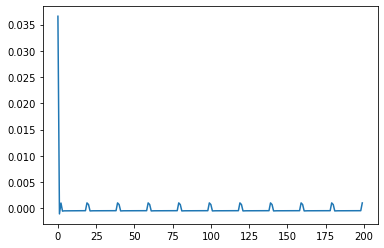

In [183]:
fig, ax = plt.subplots()
ax.plot(dxp_g_arr[:,1])
# ax2 = ax.twinx()
# ax2.plot(np.diff(dxp_g_arr[:,1]), color='darksalmon')
# ax.set_ylim(-0.00005, 0.00005)

In [185]:
xp = g_args[0]
x_minus_xp_arr = x_arr - xp

In [186]:
dxp_g_median = np.median(dxp_g_arr[:,0])
dxp_arr = np.linspace(dxp_g_median-0.0001,dxp_g_median+0.0001,101)
g_arr = np.asarray([g_func(dxp, *g_args) for dxp in dxp_arr])

In [187]:
box_xmax - xp

0.5453982928357552

In [188]:
g_func(0.0, *g_args)

0.03818444574416336

In [189]:
xp = g_args[0]
x_minus_xp_arr = x_arr - xp

In [190]:
dxp_macrosco_arr = np.linspace(-0.01, 0.02, 101)
g_macrosco_arr = np.asarray([g_func(dxp, *g_args) for dxp in dxp_macrosco_arr])

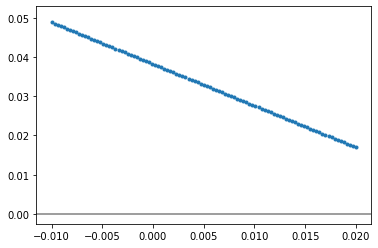

In [191]:
fig, ax = plt.subplots()
ax.plot(dxp_macrosco_arr, g_macrosco_arr, '.')
ax.set_xlim(*ax.get_xlim())
ax.vlines(x_minus_xp_arr, *ax.get_ylim(), linestyle='--', linewidth=0.5)
ax.hlines(0, *ax.get_xlim(), color='gray')
# fig.savefig("discontinous-probably-due-to-malicious-extended-func-test-1.png")

In [192]:
g_func(0.0, *g_args)

0.03818444574416336

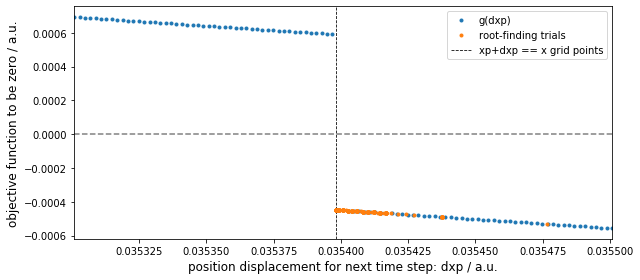

In [193]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(dxp_arr, g_arr, '.', label='g(dxp)')
ax.set_ylim(*ax.get_ylim())
ax.set_xlim(*dxp_arr[[0,-1]])

ax.vlines(x_minus_xp_arr, *ax.get_ylim(), linestyle='--', linewidth=0.8, label='xp+dxp == x grid points')

ax.plot(dxp_arr[[0,-1]], [0,0], '--', color='gray')
if dxp_g_arr.size > 0:
    ax.plot(dxp_g_arr[:,0], dxp_g_arr[:,1], '.', label='root-finding trials')
    
ax.legend()
ax.set_xlabel("position displacement for next time step: dxp / a.u.", fontsize='large')
ax.set_ylabel("objective function to be zero / a.u.", fontsize='large')
fig.tight_layout()
# fig.savefig("discontinuous-nature-of-obj-func-to-be-zero-test-4.png")

# [..may be not][TODO] Let's just use jacobian instead of approximation, since it isn't too hard to evaluate

#### Animate propagation

In [ ]:
# %matplotlib notebook

# from matplotlib.animation import FuncAnimation

In [ ]:
# fig, ax = plt.subplots()

# l_real, = ax.plot([],[])
# l_abs, = ax.plot([],[])
# ax.set_xlim(*x_arr[[0,-1]]), ax.set_ylim(-1,1)
# text = ax.text(0,0,'')

# def init(): 
#     wf_x[:] = wf_x_t0
#     l_real.set_data(x_arr, wf_x.real)
#     l_abs.set_data(x_arr, np.abs(wf_x))
#     return l_real, l_abs
    
# def update(i):
#     prop.propagate(wf_x[1:-1], dt, Nt=10)
#     l_real.set_data(x_arr, wf_x.real)
#     l_abs.set_data(x_arr, np.abs(wf_x))
#     text.set_text(i)

# ani = FuncAnimation(fig, update, frames=15, init_func=init)